# Improved GMM with Lowered Learning Rate for Foreground Pixels

Andre Telfer, 2018

---
In this notebook we implement the GMM algorithm \[Zizkovic et al., 2006\] 

The GMM algorithm predicts foreground and background pixels by overlapping several gaussian models which represent the probability of a pixel being part of the background given its value. 

We also review the math behind the laplace kernels and compare various OpenCV Edge Detectors

## GMM Algorithms

### Updating Values
From \[Zizkovic et al., 2006\] the GMM parameters are updates following this:
$$
\begin{align}
\hat\pi_m &\leftarrow \hat\pi_m + \alpha(o^{(t)}_m - \hat\pi_m) - \alpha c_T \\
\hat\mu &\leftarrow \hat\mu + o^{(t)}_m(\alpha/\hat\pi_m)\vec\delta_m \\
\hat\sigma^2_m &\leftarrow \hat\sigma^2_m + o^{(t)}_m(\alpha/\hat\pi_m)(\vec\delta_m^T\vec\delta_m-\hat\sigma_m^2) \\
\\
\hat\pi_m &\text{: mixing weights } \\
\hat\mu  &\text{: means} \\
\hat\sigma^2_m &\text{: variance } \\
\\
x(t) &\text{: pixel values (RGB) } \\
\alpha &= \frac{1}{T} \\
\vec\delta_m &= \vec x^{(t)} - \hat\mu_m \\
c_T &= \frac{c}{T} \text{: This is roughly the maximum ratio of foreground pixels to background }\\
T &\text{: Time adaption period} \\
o^{(t)}_m &= \{1, 0\} \text{: Pixel ownership. Set to 1 for the closest model, otherwise 0. Closest model determined by D} \\
D^2_m(\vec x(t)) &= \vec\delta_m^{(t)}\vec\delta_m / \hat \sigma ^ 2_m 
\end{align} 
$$

We plan to modify this algorithm so that we prevent learning from frames that are foreground

$$
\begin{align}
\hat\pi_m &\leftarrow \hat\pi_m + \alpha(o^{(t)}_m - \hat\pi_m) - \alpha c_T \\
\hat\mu &\leftarrow \hat\mu + o^{(t)}_m(\alpha/\hat\pi_m)\vec\delta_m \\
\hat\sigma^2_m &\leftarrow \hat\sigma^2_m + o^{(t)}_m(\alpha/\hat\pi_m)(\vec\delta_m^T\vec\delta_m-\hat\sigma_m^2) \\
\end{align}
$$
### Prediction
Prediction made using:
$$
\begin{align}
p(\vec x^{(t)} | BG) &> c_{th} \\
c_{thr} &\text{: Some threshold} \\
BG &\text{: Background pixel} \\
p(\vec x^{(t)} | BG) &= \sum \limits^B_{m=1} \hat\pi_m \mathcal{N}(\vec x; \hat\mu_m, \sigma^2_m I) \\
B &= argmin \Big ( \sum\limits^b_{m=1}\hat\pi_m > (1 - C_T) \Big ) \\
\mathcal{N} &\text{: Gaussian model} \\
\end{align}
$$

### Generating New Components
New components are generated when $D$ is larger than some number ($d_{max}$), and are given these parameters: $\pi_{M+1} = \alpha$, $\hat\mu_{M+1} = \vec x(t)$, $\sigma  = \sigma_0$. Where $\sigma_0$ is a constant

There is usually a limit to how many components can be generated $M_{max}$

## Parameter Summary
$$
\begin{align}
c_{th} &\text{: Probability threshold of a pixel belonging to the background} \\
c_{f} &\text{: Resists classifying motionless foreground pixels as background} \\
c &\text{: Maximum ratio of foreground to background pixels} \\
d_{max} &\text{: Maximum distance from model before a new model is generated} \\
M_{max} &\text{: Maximum number of background models representing each pixel} \\
\sigma_{0}^2 &\text{: Variance for newly created models} \\
T &\text{: Time adpation period} \\
\end{align}
$$
## References
- \[Zizkovic et al., 2006\]    
Zoran Zivkovic and Ferdinand van der Heijden. Efficient adaptive density estimation per image pixel for the task of background subtraction. Pattern recognition letters, 27(7):773–780, 2006.


## Basic Python Implementation
This is meant as poor performing pseudo code to clarify logic

In [1]:
import cv2              
import os
import numpy as np

# Resize image and make it grayscale for simplicity
frame_width, frame_height = [400,400]
def get_frame():
    ret, frame = cap.read()
#     dst = np.zeros(shape=frame.shape)
    dst = cv2.resize(src=frame, dsize=(frame_width, frame_height));
    grey =  cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    return grey

class GMM:
    def __init__(self, frame_width, frame_height, c=0.03, cf=0.2, cth=0.01, mmax=5, dmax=30, var0=25, t=15):
        '''
        Input:
        c    -- contributes to degradation of model weights
        cf   -- the maximum weight a model can have and still be considered part of the background
        cth  -- threshold for foreground/background
        mmax -- maximum number of models for each pixel
        dmax -- max normalized distance from a pixel to a model
        var0 -- the initial variance given to new models
        t    -- how many frames are stored in memory, or the inverse learning/forgetting rate
        
        Output:
        A segmented image
        '''
        self.frame_width  = frame_width
        self.frame_height = frame_height
        self.cth          = cth  
        self.cf           = cf
        self.c            = c
        self.mmax         = mmax
        self.dmax         = dmax
        self.var0         = 3**2
        self.t            = t
        
        # derived parameters
        self.alpha = 1/t # learning rate
        self.ct    = c/t # starting weight for models and additional forgetting component

        # Initialize arrays
        self.means = np.zeros(shape=(frame_width, frame_height, mmax))
        self.variance = np.zeros(shape=(frame_width, frame_height, mmax))
        self.weights = np.zeros(shape=(frame_width, frame_height, mmax))

        # Because numpy arrays are of fixed size, we specify the number of models as the max
        # to find out how many models are actually created vs empty, we use this array
        self.models = np.zeros(shape=(frame_width, frame_height), dtype=np.int)

        # Distance function: we're using grey scale so no need for Mahalanobis distance
        self.distance = lambda x, sigma, mean: \
            abs(mean - x) / sigma

        # Simple gaussian implementation 
        self.gaussian = lambda x, weight, mean, sigma: \
            weight * np.exp(-0.5 * (mean - x) ** 2 / (2 * sigma) ) / (sigma * np.sqrt(2 * np.pi))

    def apply(self, x):
        '''
        Input:
        x -- a frame
        '''
        # first, let's figure out whether each pixel is foreground or background
        sigma = np.sqrt(self.variance)
        segmentation = np.zeros(shape=x.shape)
        for i in range(self.frame_width):
            for j in range(self.frame_height):
                # Distances from existing models
                distances = []
                for m in range(self.models[i,j]):
                    distances.append(self.distance(x[i,j], sigma[i,j,m], self.means[i,j,m]))

                # Is a model part of the foreground or not
                prob_models = []
                model_weights = []
                for m in np.argsort(self.weights[i,j,:])[::-1]:
                    if self.weights[i,j,m] == 0:
                        break
                    if sum(model_weights) < 1 - self.cf:
                        prob_models.append(self.gaussian(x[i,j], self.weights[i,j,m], self.means[i,j,m], sigma[i,j,m]))
                        model_weights.append(self.weights[i,j,m])
                    else:
                        break
                segmentation[i,j] = sum(prob_models) < self.cth

                # Create a model or not?
                create_model = False
                if self.models[i, j] == 0:
                    # If there are no models, initialize
                    create_model = True
                elif self.models[i,j] < self.mmax:
                    # If pixel is too far away from an existing model, create a new one
                    if min(distances) > self.dmax:
                        create_model = True

                # create a new model
                if create_model:
                    self.models[i,j] += 1
                    m = self.models[i,j] - 1
                    self.weights[i,j,m] = self.alpha
                    self.means[i,j,m] = x[i,j]
                    self.variance[i,j,m] = self.var0
                else:
                    # get the model that's the closest
                    m = np.argmin(distances)  

                    # model weights degrade over time
                    for m in range(self.models[i,j]):
                        self.weights[i,j,m] -= self.alpha * (self.weights[i,j,m] + self.ct)

                    # update
                    assert sigma[i,j,m] != 0
                    delta = x[i,j] - self.means[i,j,m]  
                    self.weights[i,j,m] += self.alpha 
                    self.means[i,j,m] += self.alpha / self.weights[i,j,m] * delta 
                    variance_update = self.alpha / self.weights[i,j,m] * (delta**2 - self.variance[i,j,m])
                    self.variance[i,j,m] = self.variance[i,j,m] + variance_update

        return segmentation

In [2]:
%%time
# Load video
video_file = os.path.join(os.getcwd(), '../video_fish_A.avi')
cap = cv2.VideoCapture(video_file)
assert cap.isOpened(), "Error opening video file"

print("FPS:", cap.get(cv2.CAP_PROP_FPS))
mog = GMM(frame_width,frame_height)
for _ in range(10):
    frame = get_frame()
    foreground = mog.apply(frame)
    if foreground is None: break
        

FPS: 19.05
CPU times: user 1min 4s, sys: 140 ms, total: 1min 4s
Wall time: 1min 4s


### Results
Here we display the results from the last video frame. Here we explore
- applying our adaptive GMM to the frame to extract the foreground
- applying an 'erosion' transformation to the foreground
- applying an 'open'  transformation to the foreground

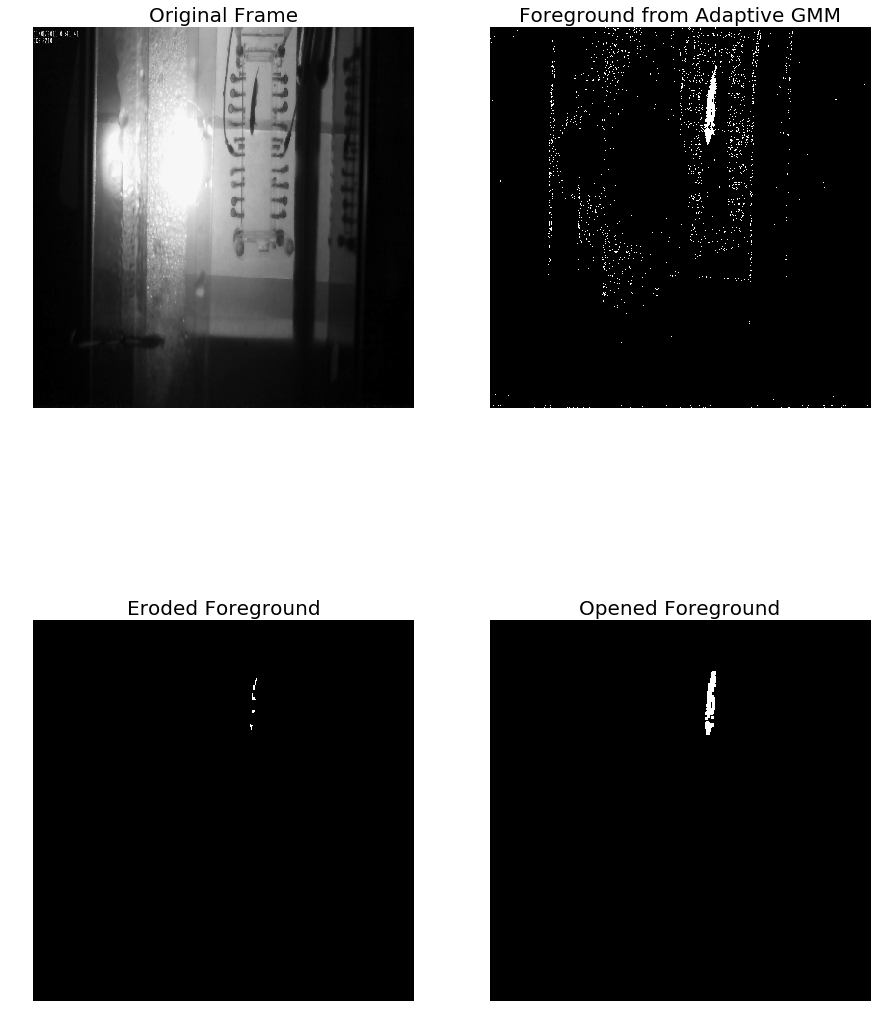

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15,20))
plt.subplot(222)
plt.axis('off')
plt.title('Foreground from Adaptive GMM', fontsize=20)
plt.imshow(foreground, 'gray')

plt.subplot(221)
plt.axis('off')
plt.title('Original Frame', fontsize=20)
plt.imshow(frame, 'gray')

kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(foreground,kernel,iterations = 2)
plt.subplot(223)
plt.axis('off')
plt.title('Eroded Foreground', fontsize=20)
plt.imshow(erosion, 'gray')

kernel = np.ones((3,3),np.uint8)
open_morph = cv2.morphologyEx(foreground, cv2.MORPH_OPEN, kernel)
plt.subplot(224)
plt.axis('off')
plt.title('Opened Foreground', fontsize=20)
plt.imshow(open_morph, 'gray')

# Laplacian Transformation
The Laplace Transformation $\mathcal{L}$ is a useful form of edge detection. As the second derivative, a large $\mathcal{L}$ means an accelerating first derivative, while a low $\mathcal{L}$ means a consistent one. Because of this behaviour, the a high second derivative is useful when finding boundaries between objects 

To find $\mathcal{L}$ at a specific pixel, we create a numerical approximatation from its surrounding pixels

$$
\begin{align}
\mathcal{L} &= \nabla^2 f(x,y) \\
\mathcal{L} &= \frac{d^2 f}{dx^2} + \frac{d^2 f}{dy^2} \\
\end{align}
$$

We approximate the second derivate to point $p$ in a single dimension given.
$$
\begin{align}
\frac{df}{dx} &= \frac{f(x+0.5h) - f(x-0.5h)}{h}\\
\frac{d^2f}{dx^2}&= \frac{d}{dx}\frac{f(x+0.5h) - f(x-0.5h)}{h} \\
&= \frac{1}{h} \Big[\frac{f(x+h) - f(x)}{h} - \frac{f(x) - f(x-h)}{h} \Big]\\
&= \frac{f(x+h) + f(x-h) - 2f(x)}{h^2} 
\end{align}
$$

For $h=1$

$$
\frac{d^2f}{dx^2} = \begin{bmatrix} 1 &-2 &1 \end{bmatrix} \begin{bmatrix} x_1 \\ x_0 \\ x_{-1} \end{bmatrix} \\
$$

In two dimensions for $h=1$ this works out to
$$
\begin{bmatrix} 
    0 &1 &0\\
    1 &-4 &1\\
    0 &1 &0\\
\end{bmatrix} 
$$

### References
- Kris Kitani. Image Gradients and Gradient Filtering. Carnegie Mellon (Lecture Slides), 2017.    
http://www.cs.cmu.edu/~16385/s17/Slides/4.0_Image_Gradients_and_Gradient_Filtering.pdf

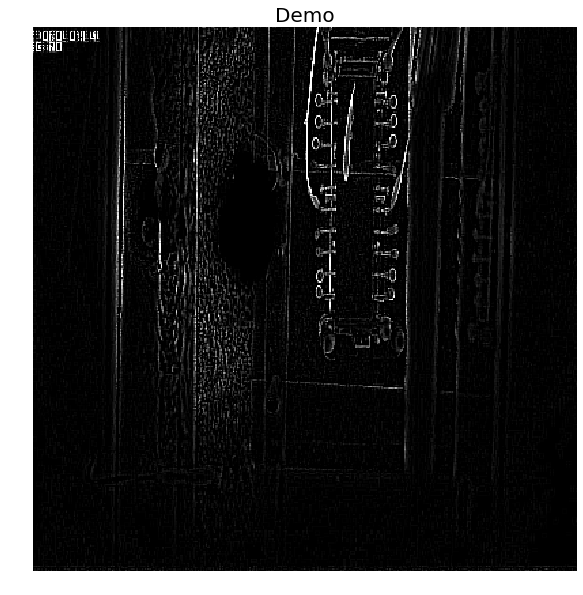

In [4]:
laplace = cv2.Laplacian(frame, ddepth=0, ksize=3)

plt.figure(figsize=(15,10))
plt.axis('off')
plt.title('Demo', fontsize=20)
plt.imshow(laplace, 'gray')

## Edge Detection Comparrison

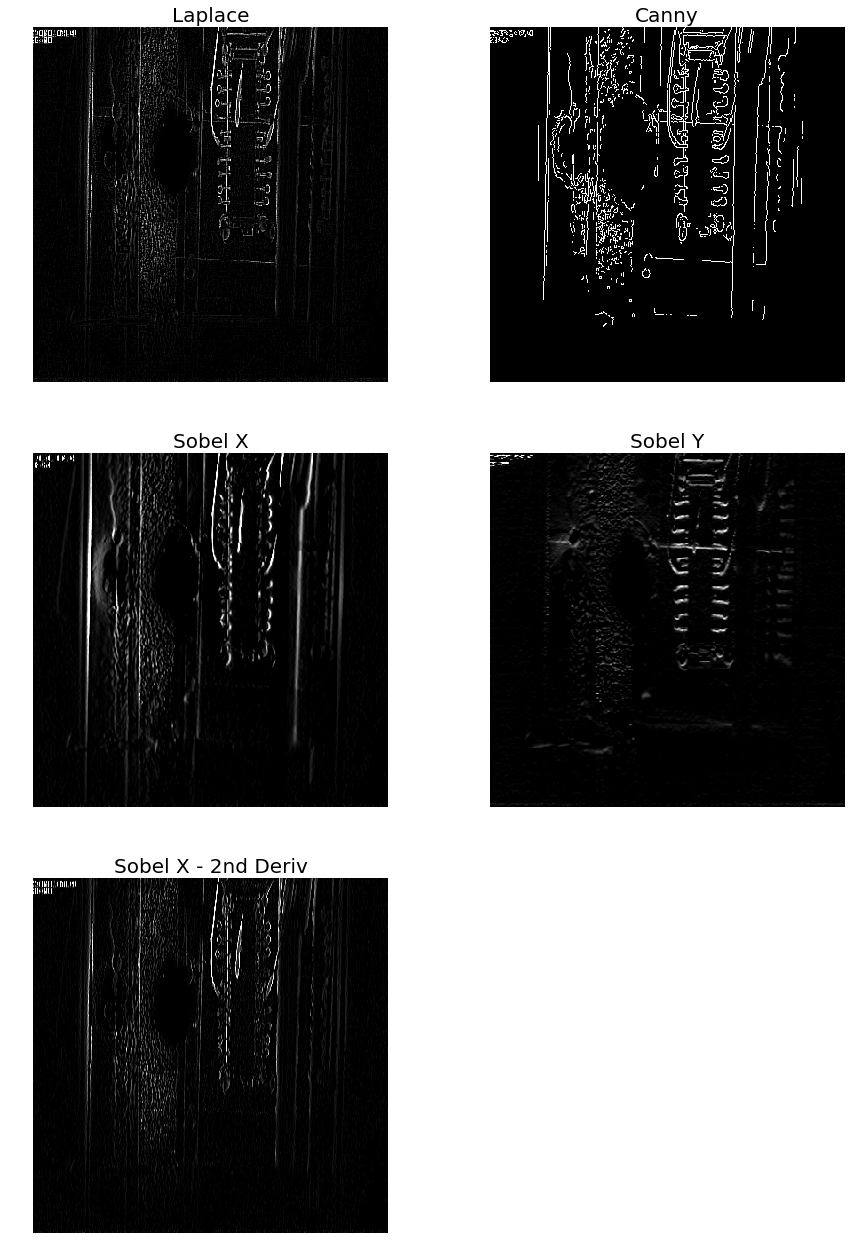

In [132]:
plt.figure(figsize=(15,30))

# laplace
plt.subplot(421)
laplace = cv2.Laplacian(frame, ddepth=0, ksize=3)
plt.axis('off')
plt.title('Laplace', fontsize=20)
plt.imshow(laplace, 'gray')

# canny
plt.subplot(422)
canny = cv2.Canny(frame, 75, 100)
plt.axis('off')
plt.title('Canny', fontsize=20)
plt.imshow(canny, 'gray')

# sobel
plt.subplot(423)
sobel = cv2.Sobel(frame, ddepth=0, dx=1, dy=0, ksize=3);
plt.axis('off')
plt.title('Sobel X', fontsize=20)
plt.imshow(sobel, 'gray')

plt.subplot(424)
sobel = cv2.Sobel(frame, ddepth=0, dx=0, dy=1, ksize=3);
plt.axis('off')
plt.title('Sobel Y', fontsize=20)
plt.imshow(sobel, 'gray')

plt.subplot(425)
sobel = cv2.Sobel(frame, ddepth=0, dx=2, dy=0, ksize=3);
plt.axis('off')
plt.title('Sobel X - 2nd Deriv', fontsize=20)
plt.imshow(sobel, 'gray')

Notes
- Missing fish, perhaps due to fish movement. Could be fixed by lowering learning rate?
- Adaptive learning rate? Decrease over time and learn slower from foreground pixels
- Additional Resources 
  - Computer Vision Course Slides: Carnegie Melon     
  http://www.cs.cmu.edu/~16385/    
  http://www.cs.cmu.edu/~16385/s17/    